In [1]:
import json
import re
import os
from pathlib import Path

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import torch
import torchvision.transforms.functional as TF
from einops import rearrange
from tifffile import TiffFile
from ome_types import from_tiff, from_xml

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.utils as utils
from mushroom.dataloaders import incorporate_hi_res

In [5]:
def adata_from_visium(fp):
    sid = fp.split('/')[-1]
    a = sc.read_visium(fp)
    a.var_names_make_unique()
    a.obsm['spatial'] = a.obsm['spatial'].astype(int)
    return a

In [11]:
run_dir = '/data/estorrs/mushroom/data/test_registration/HT397B1_v2'
out_dir = os.path.join(run_dir, 'slices_unregistered')
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [12]:
fps = [
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U1',
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U21',
]
sid_to_adata = {fp.split('/')[-1]:utils.adata_from_visium(fp) for fp in fps}

fps = {
    'HT397B1-S1H3A1U1':  '/data/spatial_transcriptomics/highres_images/breast/A1_HT397B1-S1H3A1U1.tif',
    'HT397B1-S1H3A1U21': '/data/spatial_transcriptomics/highres_images/breast/B1_HT397B1-S1H3A1U21.tif',
}

sid_to_he = {sid:tifffile.imread(fp) for sid, fp in fps.items()}
sid_to_he.keys()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


dict_keys(['HT397B1-S1H3A1U1', 'HT397B1-S1H3A1U21'])

In [7]:
fps = sorted(utils.listfiles('/data/multiplex_imaging/codex/htan/brca', regex=r'ome.tiff$'))
fps

['/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff',
 '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff',
 '/data/multiplex_imaging/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1_S1H1A3U31_04062023.ome.tiff',
 '/data/multiplex_imaging/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_2/HT397B1_S1H1A3U22_04122023.ome.tiff']

In [8]:
utils.get_ome_tiff_channels(fps[0])

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


['DAPI',
 'CD8',
 'Her2 (D)',
 'GATA3 (D)',
 'cKIT-(D)',
 'Pan-Cytokeratin',
 'GLUT1-(D)',
 'Podoplanin',
 'CD68 (D)',
 'HLA-DR',
 'Keratin 14',
 'FoxP3',
 'MGP-(D)',
 'CD20-(D)',
 'SMA-(D)',
 'Ki67',
 'Vimentin-(D)',
 'PR-(D)',
 'Bap1 (D)',
 'CD45 (D)',
 'ER',
 'CD31',
 'COX6c (D)',
 'CK19',
 'PLAT/tPA (D)']

In [9]:
sid_to_fp = {
    'HT397B1-S1H3A1U2': '/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff',
    'HT397B1-S1H3A1U12': '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff',
    'HT397B1-S1H3A1U22': '/data/multiplex_imaging/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_2/HT397B1_S1H1A3U22_04122023.ome.tiff',
    'HT397B1-S1H3A1U31': '/data/multiplex_imaging/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1_S1H1A3U31_04062023.ome.tiff'
}

cmap = {
    'DAPI': (0., 0., 1.),
    'Pan-Cytokeratin': (1., 0., 0.),
    'CD45 (D)': (0., 1., 0.),
    'SMA-(D)': (1., 1., 1.)
}

sid_to_pseudo = {}
for k, v in sid_to_fp.items():
    print(k)
    d = utils.extract_ome_tiff(v, channels=list(cmap.keys()))
    pseudo = utils.make_pseudo(d, cmap=cmap, contrast_pct=90.)
    sid_to_pseudo[k] = pseudo



HT397B1-S1H3A1U2
HT397B1-S1H3A1U12
HT397B1-S1H3A1U22
HT397B1-S1H3A1U31


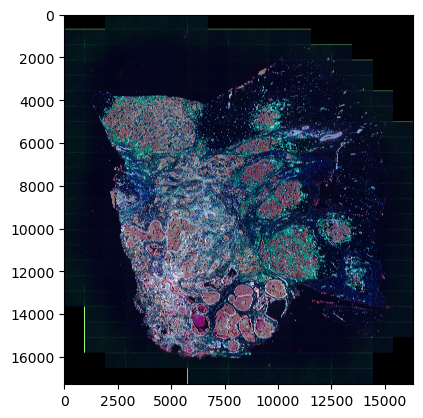

In [10]:
plt.imshow(sid_to_pseudo['HT397B1-S1H3A1U2'])

##### scale to same size

In [13]:
phenocycler_pixels_per_micron = 1.9604911906033102 # from andrew on HT206
downsample_scaler = .1 # how much to downsample images so they run faster on imagej for registration

In [14]:
sid_to_he_scaled = {}
for sid, he in sid_to_he.items():
    a = sid_to_adata[sid]
    pix_per_micron = next(iter(a.uns['spatial'].values()))['scalefactors']['spot_diameter_fullres'] / 65.
    scale = 1 / pix_per_micron * phenocycler_pixels_per_micron # bring to codex resolution
    scale *= downsample_scaler
    
    x = rearrange(torch.tensor(he), 'h w c -> c h w')
    x = TF.resize(x, (int(x.shape[-2] * scale), int(x.shape[-1] * scale)))
    x = TF.convert_image_dtype(x, torch.uint8)
    x = rearrange(x.numpy(), 'c h w -> h w c')
    
    incorporate_hi_res(a, he, scale=1., is_fullres=True, trim=False)
    labeled = a.uns[f'trimmed_1.0_labeled_img']
    labeled = TF.resize(torch.tensor(labeled.astype(np.int32)).unsqueeze(0),
                        (int(labeled.shape[-2] * scale), int(labeled.shape[-1] * scale))).squeeze()
    labeled = labeled.numpy().astype(np.uint16)
    
    sid_to_he_scaled[sid] = {
        'rgb': x,
        'voxels': labeled
    }
    

In [15]:
sid_to_codex_scaled = {}
for sid, pseudo in sid_to_pseudo.items():
    scale = 1. # scaling to codex res for now
    scale *= downsample_scaler
    
    x = rearrange(torch.tensor(pseudo), 'h w c -> c h w')
    x = TF.resize(x, (int(x.shape[-2] * scale), int(x.shape[-1] * scale)))
    x = TF.convert_image_dtype(x, torch.uint8)
    sid_to_codex_scaled[sid] = rearrange(x.numpy(), 'c h w -> h w c')

In [16]:
combined = sid_to_he_scaled.copy()
combined.update(sid_to_codex_scaled)

In [17]:
nums = np.asarray([int(re.sub(r'^.*[^0-9]([0-9]+)$', r'\1', x)) for x in combined.keys()])
order = np.asarray(list(combined.keys()))[np.argsort(nums)]
order

array(['HT397B1-S1H3A1U1', 'HT397B1-S1H3A1U2', 'HT397B1-S1H3A1U12',
       'HT397B1-S1H3A1U21', 'HT397B1-S1H3A1U22', 'HT397B1-S1H3A1U31'],
      dtype='<U17')

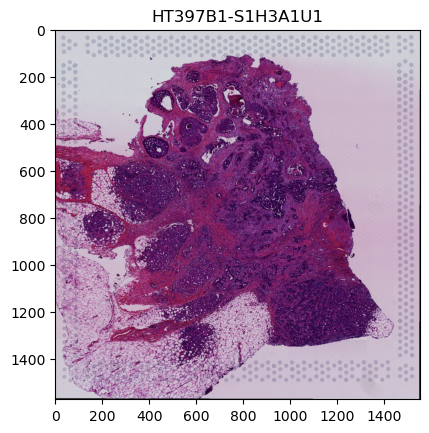

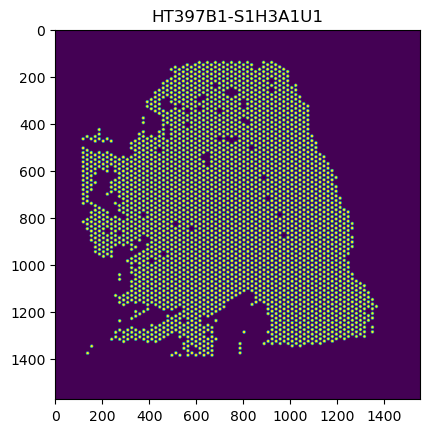

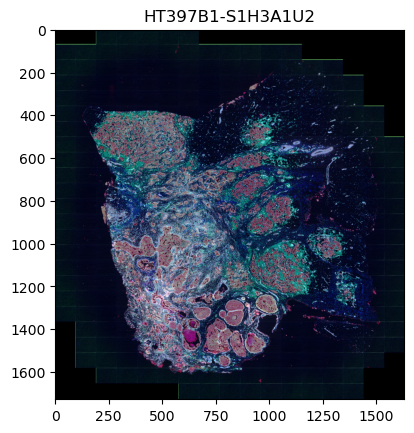

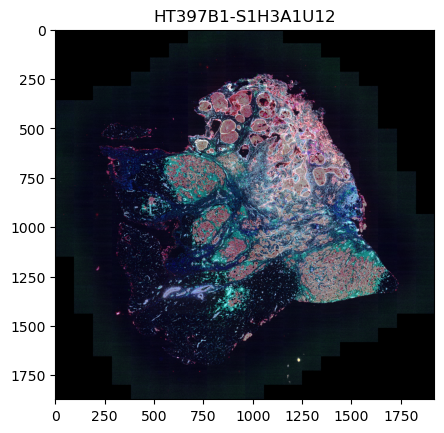

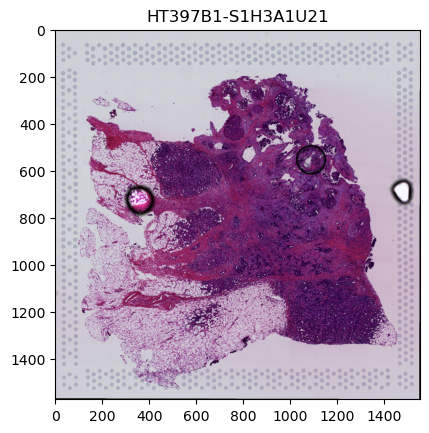

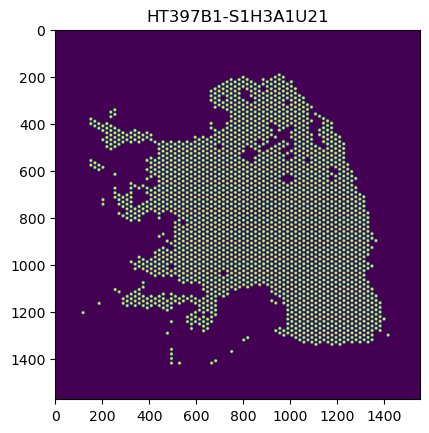

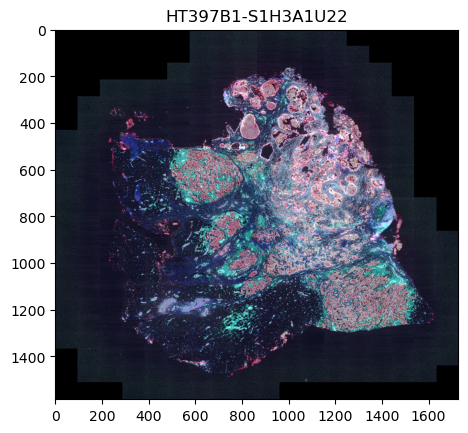

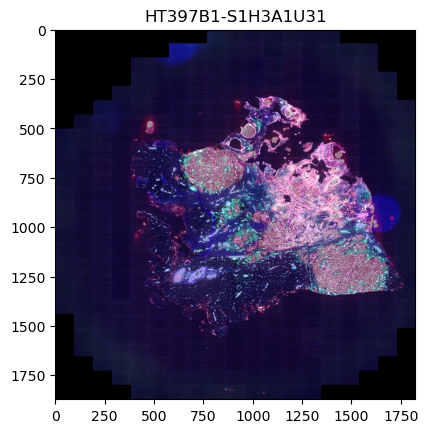

In [18]:
for sid in order:
    x = combined[sid]
    if isinstance(x, dict):
        plt.imshow(x['rgb'])
        plt.title(sid)
        plt.show()
        plt.imshow(x['voxels']!=0)
        plt.title(sid)
        plt.show()
    else:
        plt.imshow(x)
        plt.title(sid)
        plt.show()

In [19]:
for i, sid in enumerate(order):
    img = combined[sid]
    if not isinstance(img, dict):
        tifffile.imwrite(os.path.join(out_dir, f's{i}_{sid}_codex.tif'), img)
    else:
        tifffile.imwrite(os.path.join(out_dir, f's{i}_{sid}_rgb.tif'), img['rgb'])
        tifffile.imwrite(os.path.join(out_dir, f's{i}_{sid}_voxels.tif'), img['voxels'])

In [21]:
d = {
    'downsample_scaler': downsample_scaler,
    'phenocycler_pixels_per_micron': phenocycler_pixels_per_micron,
#     'fixed_shape': 
    'order': list(order)
}
json.dump(d, open(os.path.join(out_dir, 'metadata.json'), 'w'))